In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"cores":[],"mean":[],"meanerr":[],"throughput_GB_s":[]}
timedir = "hl-d102-20211111-1numanode-8cores/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = datasetsize * readpercent
for f in os.listdir(timedir):
    array = numpy.genfromtxt(timedir+"/"+f, skip_header=1)
    nodes = f.split("_")[5].replace("cores.csv","")
    time_mean = numpy.mean(array)
    times["cores"].append(int(nodes))
    times["mean"].append(round(time_mean, 2))
    times["meanerr"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10, 9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="cores").reset_index(drop=True).copy()
timesdf

,cores,mean,meanerr,throughput_GB_s
0,4,45.52,0.49,2.748440
1,6,32.64,0.29,3.832837
2,8,28.63,0.22,4.369674


In [3]:
throughput_1node = timesdf["throughput_GB_s"][0]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,cores,mean,meanerr,throughput_GB_s,throughputspeedup
0,4,45.52,0.49,2.748440,1.000000
1,6,32.64,0.29,3.832837,1.394550
2,8,28.63,0.22,4.369674,1.589874


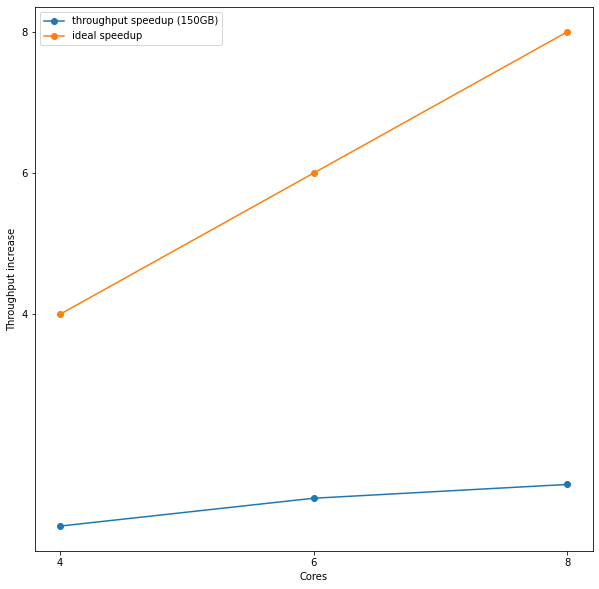

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughputspeedup"], label="throughput speedup (150GB)", marker="o")
pyplot.plot(timesdf["cores"], timesdf["cores"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["cores"])
pyplot.yticks(timesdf["cores"])
pyplot.xlabel("Cores")
pyplot.ylabel("Throughput increase")
pyplot.legend()

No handles with labels found to put in legend.


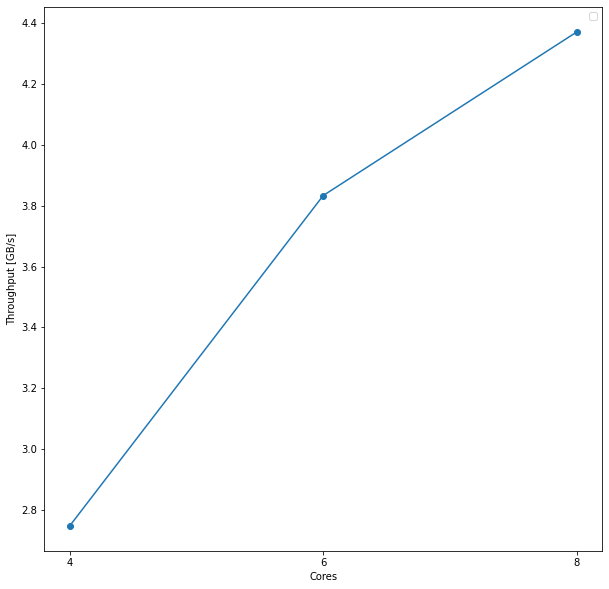

In [5]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughput_GB_s"], marker="o")
pyplot.xticks(timesdf["cores"])

pyplot.xlabel("Cores")
pyplot.ylabel("Throughput [GB/s]")
pyplot.legend()

# RNTuple read throughput

In [6]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "hl-d102-20211111-1numanode-8cores"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = timedir.split("_")[2].replace("cores","")
    chunks = nodes
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[1].replace("task","")
        df["taskid"] = int(taskid)
        df["cores"] = int(nodes)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="cores").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,cores
0,41.437,6217134385,4541,28235189400,3,4
1,45.275,6156552750,4586,28235189400,0,4
2,46.563,6183010568,4566,28235189400,0,4
3,43.731,7675537733,3678,28235189400,0,4
4,43.073,6259420962,4510,28235189400,0,4
...,...,...,...,...,...,...
157,26.251,13340178839,1058,14117594700,1,8
158,27.662,13266691426,1064,14117594700,1,8
159,24.757,12900542691,1094,14117594700,1,8
160,26.832,13405992391,1053,14117594700,3,8


In [7]:
meantaskthroughput = df.groupby(["cores"]).mean()[["taskruntime","taskreadtime","readthroughput","readpayload"]]
meantaskthroughput = meantaskthroughput.reset_index().sort_values("cores").reset_index(drop=True)
meantaskthroughput["taskreadtime_s"] = meantaskthroughput["taskreadtime"] / 1000000000
meantaskthroughput

,cores,taskruntime,taskreadtime,readthroughput,readpayload,taskreadtime_s
0,4,43.159444,6.757633e+09,4229.500000,2.823519e+10,6.757633
1,6,30.888907,5.494830e+09,3480.814815,1.882346e+10,5.494830
2,8,27.327250,1.322988e+10,1068.972222,1.411759e+10,13.229882


Text(0, 0.5, 'Average Task Throughput [MB/s]')

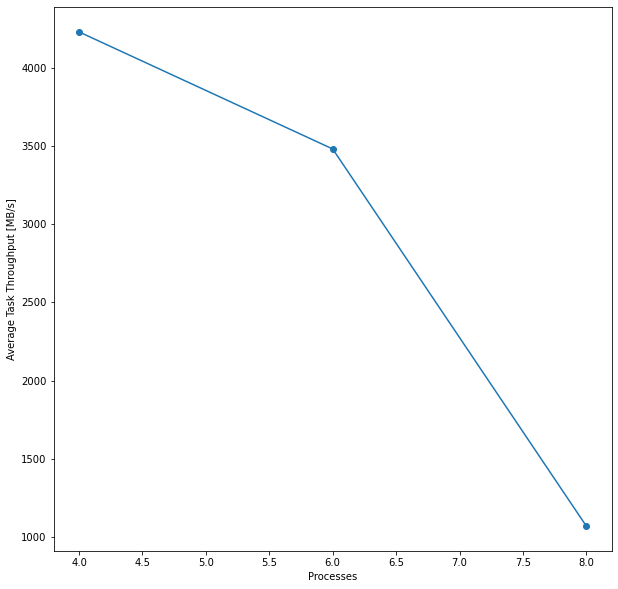

In [8]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["readthroughput"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Average Task Throughput [MB/s]")

Text(0, 0.5, 'Time [s]')

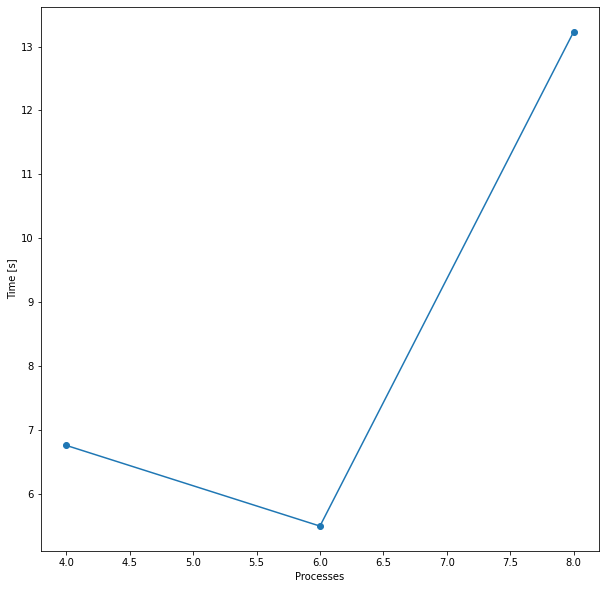

In [9]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["taskreadtime_s"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Time [s]")

In [10]:
sumthroughput = df.groupby(["cores","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["cores"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,cores,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,4,6,172.637778,2.703053e+10,16918.000000,1.129408e+11,16.521484
1,6,15,185.333444,3.296898e+10,20884.888889,1.129408e+11,20.395399
2,8,28,218.618000,1.058391e+11,8551.777778,1.129408e+11,8.351345


Text(0, 0.5, 'Raw IO Throughput [GB/s]')

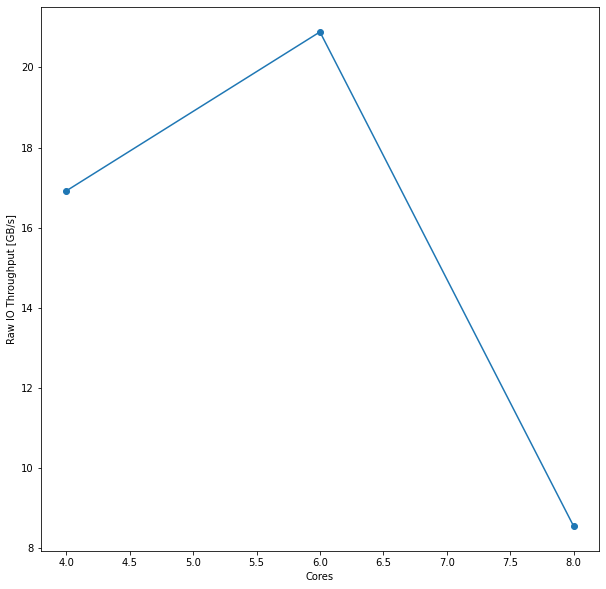

In [11]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughput"]/1000, marker="o")
pyplot.xlabel("Cores")
pyplot.ylabel("Raw IO Throughput [GB/s]")

# TGraph

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughput.png has been created


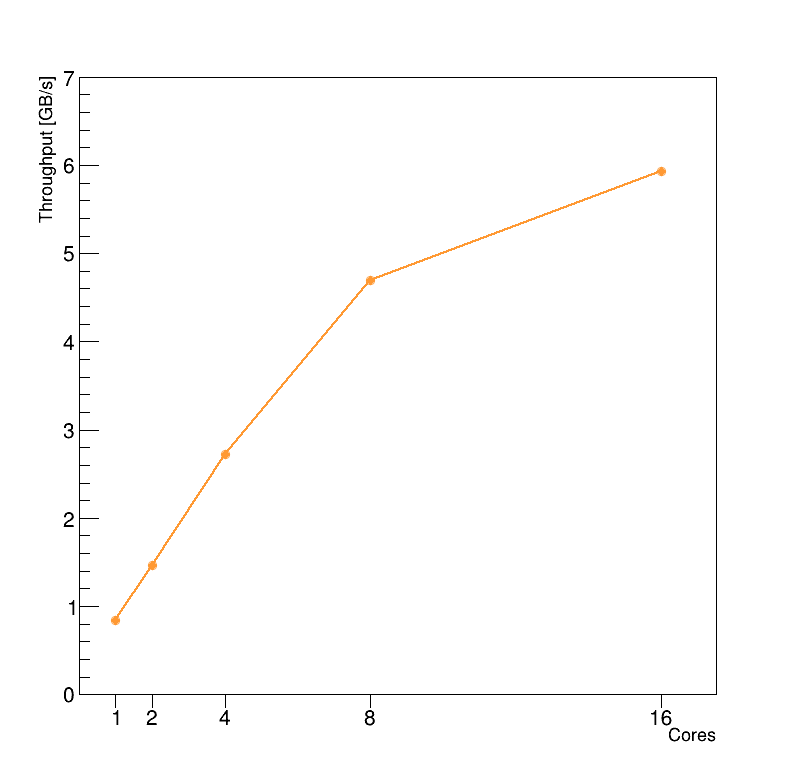

In [151]:
runtimegraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 7)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(5):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_processingthroughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughputspeedup.png has been created


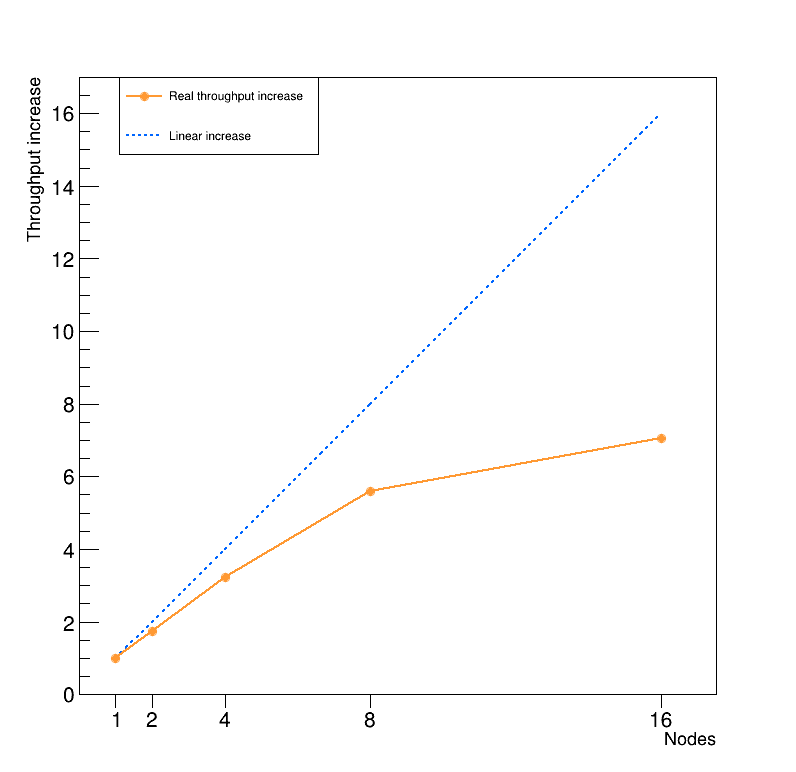

In [149]:
speedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["cores"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput increase")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 17)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["cores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.9, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph, "Real throughput increase")
legend.AddEntry(idealspeedupgraph, "Linear increase", "L")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_singlenode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_readthroughput.png has been created


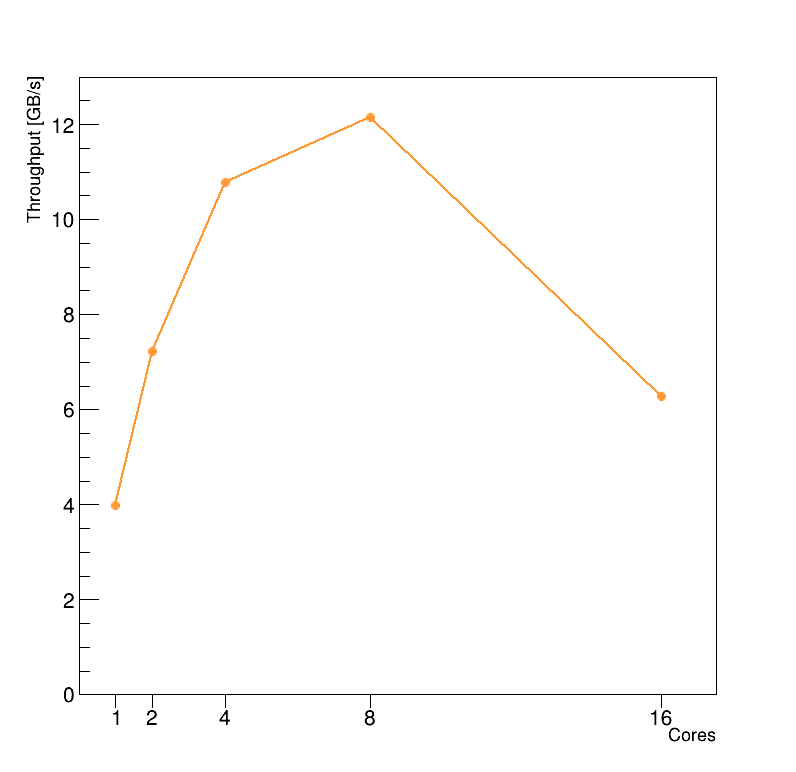

In [150]:
runtimegraph = ROOT.TGraph(len(sumthroughput["cores"]), numpy.array(sumthroughput["cores"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 13)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(sumthroughput["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_readthroughput.png")